In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)
library(tidyr)
library(RColorBrewer)
library(gridExtra)
library(stats)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###This file is from the [make l2fc notebook](./Sparsity_make_l2fc_table.ipynb)

In [4]:
%%R
FDR = 0.10

df.rspndrs = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")
df.rspndrs = subset(df.rspndrs, Treatment %in% c("13C000", "13C100"))

df.rspndrs = df.rspndrs %>%
    group_by(OTU, Treatment, Day) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose Only", "RE.Continuous"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13C000", "13C100")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, Day, rspnse)

df.rspndrs

Source: local data frame [728 x 3]

         OTU Day         rspnse
1      OTU.1  14 Cellulose Only
2     OTU.10  14           Both
3     OTU.10  28           Both
4     OTU.10  45           Both
5   OTU.1009  14 Cellulose Only
6   OTU.1009  28  RE.Continuous
7    OTU.101  45 Cellulose Only
8  OTU.10167  28  RE.Continuous
9  OTU.10167  45           Both
10   OTU.102  14 Cellulose Only
..       ... ...            ...


In [5]:
%%R

sample.data = read.table("/var/seq_data/priming_exp/data/l2fc_table.csv",
                         sep = ",", header = TRUE)
#sample.data$treatment = as.character(sample.data$treatment)
head(sample.data)

  sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1               0.25  14    13C000  OTU.4204    -0.20553170 1.0000000 Bacteria
2               0.25  14    13C000   OTU.467    -0.33054855 1.0000000 Bacteria
3               0.25  14    13C000   OTU.905     0.01698885 0.9827594 Bacteria
4               0.25  14    13C000  OTU.7253     0.02799601 0.9772968 Bacteria
5               0.25  14    13C000    OTU.67    -0.60115954 1.0000000 Bacteria
6               0.25  14    13C000 OTU.10580     0.36193427 0.7248674 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria

In [6]:
%%R
d = sample.data %>% 
    select(OTU, Treatment, log2FoldChange, Day) #%>% 
    #spread(Treatment, log2FoldChange)

#d$Treatment[d$Treatment == "13CC"] = "13C - Cellulose.only"
#d$Treatment[d$Treatment == "12CC"] = "Control - Cellulose.only"
#d$Treatment[d$Treatment == "13C100"] = "13C - RE.continuous"
#d$Treatment[d$Treatment == "12C100"] = "Control - RE.continuous"
#d$Treatment[d$Treatment == "13C700"] = "13C - RE.single"
#d$Treatment[d$Treatment == "12C700"] = "Control - RE.single"
sample.data$Treatment = as.character(sample.data$Treatment)
head(d)

        OTU Treatment log2FoldChange Day
1  OTU.4204    13C000    -0.20553170  14
2   OTU.467    13C000    -0.33054855  14
3   OTU.905    13C000     0.01698885  14
4  OTU.7253    13C000     0.02799601  14
5    OTU.67    13C000    -0.60115954  14
6 OTU.10580    13C000     0.36193427  14


In [7]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df1.14 = subset(d, Treatment %in% c("13C000", "13C100") & Day == "14")

df1.14 = df1.14 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.14)[4] = "C13.100"
colnames(df1.14)[3] = "C13.Cellulose.only"

head(df1.14)

       OTU Day C13.Cellulose.only    C13.100
1    OTU.1  14          2.5312369  0.4228203
2   OTU.10  14          5.2601408  3.8347954
3  OTU.100  14         -1.7255617 -1.3661103
4 OTU.1000  14         -0.1680369 -2.5393730
5 OTU.1001  14         -1.1211065 -2.0293666
6 OTU.1002  14          0.1660432  0.1393144


In [8]:
%%R

df.rspndrs.14 = subset(df.rspndrs, Day == 14)
df.rspndrs.14 = df.rspndrs.14 %>% select(OTU, rspnse)

df1.14 = left_join(df1.14, df.rspndrs.14, by = "OTU") 
df1.14$rspnse[is.na(df1.14$rspnse)] = "None"
head(df1.14)

       OTU Day C13.Cellulose.only    C13.100         rspnse
1    OTU.1  14          2.5312369  0.4228203 Cellulose Only
2   OTU.10  14          5.2601408  3.8347954           Both
3  OTU.100  14         -1.7255617 -1.3661103           None
4 OTU.1000  14         -0.1680369 -2.5393730           None
5 OTU.1001  14         -1.1211065 -2.0293666           None
6 OTU.1002  14          0.1660432  0.1393144           None


In [9]:
%%R 
#this is to make an x,y data frame of l2fc at day 28
df1.28 = subset(d, Treatment %in% c("13C000", "13C100") & Day == "28")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df1.28 = df1.28 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.28)[4] = "C13.100"
colnames(df1.28)[3] = "C13.Cellulose.only"
head(df1.28)

       OTU Day C13.Cellulose.only   C13.100
1    OTU.1  28         1.02223520 -1.250787
2   OTU.10  28         3.22257080  4.278544
3  OTU.100  28        -0.70014306 -2.543222
4 OTU.1000  28         0.03117547 -2.107977
5 OTU.1001  28        -0.01512185 -2.161112
6 OTU.1002  28        -0.38366521  0.539345


In [10]:
%%R

df.rspndrs.28 = subset(df.rspndrs, Day == 28)
df.rspndrs.28 = df.rspndrs.14 %>% select(OTU, rspnse)

df1.28 = left_join(df1.28, df.rspndrs.28, by = "OTU") 
df1.28$rspnse[is.na(df1.28$rspnse)] = "None"
head(df1.28)

       OTU Day C13.Cellulose.only   C13.100         rspnse
1    OTU.1  28         1.02223520 -1.250787 Cellulose Only
2   OTU.10  28         3.22257080  4.278544           Both
3  OTU.100  28        -0.70014306 -2.543222           None
4 OTU.1000  28         0.03117547 -2.107977           None
5 OTU.1001  28        -0.01512185 -2.161112           None
6 OTU.1002  28        -0.38366521  0.539345           None


In [11]:
%%R 
#this is to make an x,y data frame of l2fc at day 45
df1.45 = subset(d, Treatment %in% c("13C000", "13C100") & Day == "45")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df1.45 = df1.45 %>%
    spread(Treatment, log2FoldChange)
colnames(df1.45)[4] = "C13.100"
colnames(df1.45)[3] = "C13.Cellulose.only"
head(df1.45)

       OTU Day C13.Cellulose.only     C13.100
1    OTU.1  45          1.4682989 -0.14651615
2   OTU.10  45          4.0804522  4.14806097
3  OTU.100  45         -1.2673086 -1.08024308
4 OTU.1000  45         -2.7757374  0.06463674
5 OTU.1001  45          2.0372884 -0.32287469
6 OTU.1002  45          0.9885614  2.06550877


In [12]:
%%R

df.rspndrs.45 = subset(df.rspndrs, Day == 45)
df.rspndrs.45 = df.rspndrs.45 %>% select(OTU, rspnse)

df1.45 = left_join(df1.45, df.rspndrs.45, by = "OTU")
df1.45$rspnse[is.na(df1.45$rspnse)] = "None"
head(df1.45)

       OTU Day C13.Cellulose.only     C13.100 rspnse
1    OTU.1  45          1.4682989 -0.14651615   None
2   OTU.10  45          4.0804522  4.14806097   Both
3  OTU.100  45         -1.2673086 -1.08024308   None
4 OTU.1000  45         -2.7757374  0.06463674   None
5 OTU.1001  45          2.0372884 -0.32287469   None
6 OTU.1002  45          0.9885614  2.06550877   None


NULL


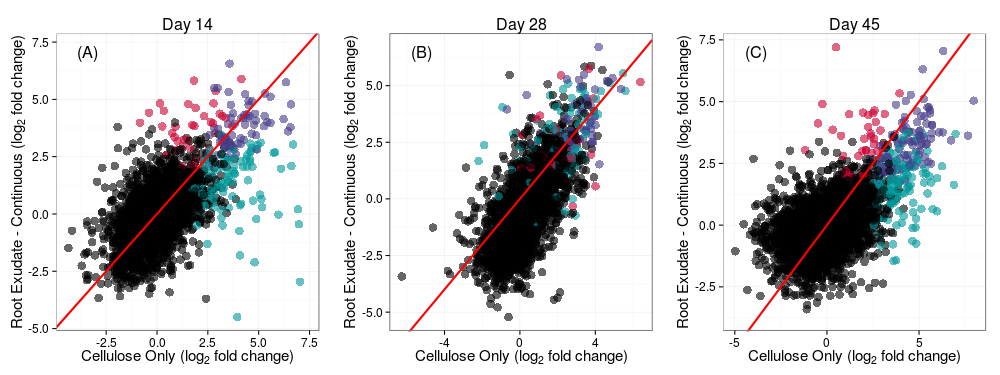

In [13]:
%%R -w 1000 -h 375

colours = c("slateblue4","#009999", "black",  "#CC0033")

p1 = ggplot(df1.14, aes(x = C13.Cellulose.only, y = C13.100, color = rspnse))
p1 = p1 + geom_point(alpha = 0.6, size = 4)
#p1 = p1 + stat_smooth(method = "lm", size = 1)
p1 = p1 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep=""))
               )
p1 = p1 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p1 = p1 + scale_color_manual(values=colours)
p1 = p1 + theme_bw()
p1 = p1 + ggtitle("Day 14")

#p1 = p1 + theme(plot.title = element_text(hjust = -0.05, size = 20))
p1 = p1 + theme(plot.title = element_text(size = 16),
                axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-1.9, y=4, label = "A", hjust=1, size=5.75)
p1 = p1 + annotate("text", label = "(A)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p1 = p1 + theme(legend.position="none")


p2 = ggplot(df1.28, aes(x = C13.Cellulose.only, y = C13.100, color = rspnse))
p2 = p2 + geom_point(alpha = 0.6, size = 4)
#p2 = p2 + stat_smooth(method = "lm", size = 1)
p2 = p2 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep=""))
               )
p2 = p2 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))
p2 = p2 + scale_color_manual(values=colours)
p2 = p2 + theme_bw()
p2 = p2 + ggtitle("Day 28")
p2 = p2 + theme(plot.title = element_text(size = 16),
                axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
p2 = p2 + annotate("text", label = "(B)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p2 = p2 + theme(legend.position="none")


p3 = ggplot(df1.45, aes(x = C13.Cellulose.only, y = C13.100, color = rspnse))
p3 = p3 + geom_point(alpha = 0.6, size = 4)
#p3 = p3 + stat_smooth(method = "lm", size = 1)
p3 = p3 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep=""))
               )
p3 = p3 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))
p3 = p3 + scale_color_manual(values=colours)
p3 = p3 + theme_bw()
p3 = p3 + ggtitle("Day 45")
p3 = p3 + theme(plot.title = element_text(size = 16),
                axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
p3 = p3 + annotate("text", label = "(C)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p3 = p3 + theme(legend.position="none")

p.combined = grid.arrange(p1, p2, p3, widths = c(1,1,1), heights = c(1,1,1), ncol = 3)

p.combined

In [14]:
%%R
FDR = 0.10

df.rspndrs2 = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")
df.rspndrs2 = subset(df.rspndrs2, Treatment %in% c("13C000", "13C700"))

df.rspndrs2 = df.rspndrs2 %>%
    group_by(OTU, Treatment, Day) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose Only", "RE.Pulse"))
}

df.rspndrs2$rspnse = apply(df.rspndrs2[,c("13C000", "13C700")], 1, rspnse)

df.rspndrs2 = df.rspndrs2 %>% select(OTU, Day, rspnse)

df.rspndrs2

Source: local data frame [797 x 3]

         OTU Day         rspnse
1      OTU.1  14 Cellulose Only
2     OTU.10  14           Both
3     OTU.10  28           Both
4     OTU.10  45           Both
5   OTU.1009  14           Both
6   OTU.1009  28       RE.Pulse
7    OTU.101  45 Cellulose Only
8   OTU.1016  14       RE.Pulse
9  OTU.10167  45           Both
10 OTU.10192  14       RE.Pulse
..       ... ...            ...


In [15]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.14 = subset(d, Treatment %in% c("13C000", "13C700") & Day == "14")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.14 = df2.14 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.14)[4] = "C13.700"
colnames(df2.14)[3] = "C13.Cellulose.only"
head(df2.14)

       OTU Day C13.Cellulose.only    C13.700
1    OTU.1  14          2.5312369  0.7034319
2   OTU.10  14          5.2601408  5.9446524
3  OTU.100  14         -1.7255617 -1.9755959
4 OTU.1000  14         -0.1680369 -1.0339771
5 OTU.1001  14         -1.1211065 -0.2288978
6 OTU.1002  14          0.1660432  3.0378168


In [16]:
%%R

df2.rspndrs.14 = subset(df.rspndrs2, Day == 14)
df2.rspndrs.14 = df2.rspndrs.14 %>% select(OTU, rspnse)

df2.14 = left_join(df2.14, df2.rspndrs.14, by = "OTU") 
df2.14$rspnse[is.na(df2.14$rspnse)] = "None"
head(df2.14)

       OTU Day C13.Cellulose.only    C13.700         rspnse
1    OTU.1  14          2.5312369  0.7034319 Cellulose Only
2   OTU.10  14          5.2601408  5.9446524           Both
3  OTU.100  14         -1.7255617 -1.9755959           None
4 OTU.1000  14         -0.1680369 -1.0339771           None
5 OTU.1001  14         -1.1211065 -0.2288978           None
6 OTU.1002  14          0.1660432  3.0378168           None


In [17]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.28 = subset(d, Treatment %in% c("13C000", "13C700") & Day == "28")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.28 = df2.28 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.28)[4] = "C13.700"
colnames(df2.28)[3] = "C13.Cellulose.only"
head(df2.28)

       OTU Day C13.Cellulose.only    C13.700
1    OTU.1  28         1.02223520  0.4140624
2   OTU.10  28         3.22257080  2.9986774
3  OTU.100  28        -0.70014306 -2.3284805
4 OTU.1000  28         0.03117547 -0.8994550
5 OTU.1001  28        -0.01512185 -0.2975219
6 OTU.1002  28        -0.38366521  1.8498655


In [18]:
%%R

df2.rspndrs.28 = subset(df.rspndrs2, Day == 28)
df2.rspndrs.28 = df2.rspndrs.28 %>% select(OTU, rspnse)

df2.28 = left_join(df2.28, df.rspndrs.28, by = "OTU") 
df2.28$rspnse[is.na(df2.28$rspnse)] = "None"
head(df2.28)

       OTU Day C13.Cellulose.only    C13.700         rspnse
1    OTU.1  28         1.02223520  0.4140624 Cellulose Only
2   OTU.10  28         3.22257080  2.9986774           Both
3  OTU.100  28        -0.70014306 -2.3284805           None
4 OTU.1000  28         0.03117547 -0.8994550           None
5 OTU.1001  28        -0.01512185 -0.2975219           None
6 OTU.1002  28        -0.38366521  1.8498655           None


In [19]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df2.45 = subset(d, Treatment %in% c("13C000", "13C700") & Day == "45")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df2.45 = df2.45 %>%
    spread(Treatment, log2FoldChange)
colnames(df2.45)[4] = "C13.700"
colnames(df2.45)[3] = "C13.Cellulose.only"
head(df2.45)

       OTU Day C13.Cellulose.only    C13.700
1    OTU.1  45          1.4682989  0.5600365
2   OTU.10  45          4.0804522  3.4008224
3  OTU.100  45         -1.2673086 -2.6533094
4 OTU.1000  45         -2.7757374  0.2205842
5 OTU.1001  45          2.0372884 -0.8692756
6 OTU.1002  45          0.9885614  1.2096044


In [20]:
%%R

df2.rspndrs.45 = subset(df.rspndrs2, Day == 45)
df2.rspndrs.45 = df2.rspndrs.45 %>% select(OTU, rspnse)

df2.45 = left_join(df2.45, df2.rspndrs.45, by = "OTU") 
df2.45$rspnse[is.na(df2.45$rspnse)] = "None"
head(df2.45)

       OTU Day C13.Cellulose.only    C13.700 rspnse
1    OTU.1  45          1.4682989  0.5600365   None
2   OTU.10  45          4.0804522  3.4008224   Both
3  OTU.100  45         -1.2673086 -2.6533094   None
4 OTU.1000  45         -2.7757374  0.2205842   None
5 OTU.1001  45          2.0372884 -0.8692756   None
6 OTU.1002  45          0.9885614  1.2096044   None


NULL


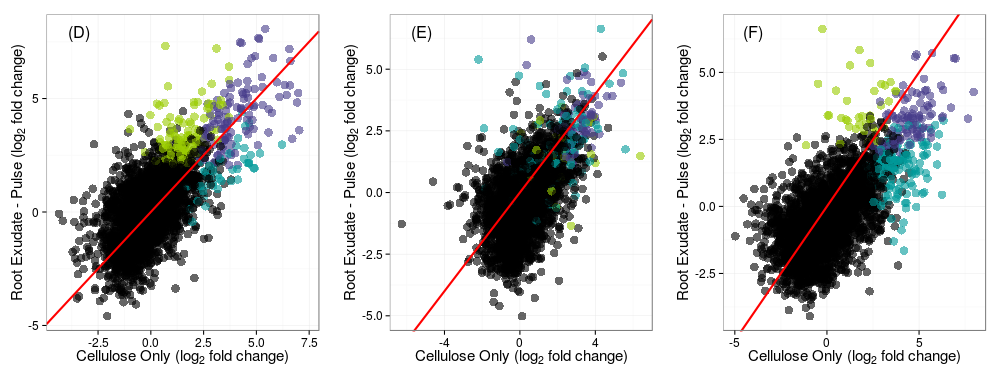

In [21]:
%%R -w 1000 -h 375

colours = c("slateblue4", "#009999", "black", "#99CC00")

p4 = ggplot(df2.14, aes(x = C13.Cellulose.only, y = C13.700, color = rspnse))
p4 = p4 + geom_point(alpha = 0.6, size = 4)
#p4 = p4 + stat_smooth(method = "lm", size = 1)
p4 = p4 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep=""))
               )
p4 = p4 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p4 = p4 + ggtitle("A")
#p4 = p4 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))
p4 = p4 + scale_color_manual(values=colours)
p4 = p4 + theme_bw()
p4 = p4 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p4 = p4 + annotate("text", label = "(D)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p4 = p4 + theme(legend.position="none")


p5 = ggplot(df2.28, aes(x = C13.Cellulose.only, y = C13.700, color = rspnse))
p5 = p5 + geom_point(alpha = 0.6, size = 4)
p5 = p5 + scale_color_manual(values=colours)
#p5 = p5 + stat_smooth(method = "lm", size = 1)
p5 = p5 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep=""))
               )
p5 = p5 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p5 = p5 + ggtitle("B")
#p5 = p5 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p5 = p5 + theme_bw()
p5 = p5 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p5 = p5 + annotate("text", label = "(E)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p5 = p5 + theme(legend.position="none")


p6 = ggplot(df2.45, aes(x = C13.Cellulose.only, y = C13.700, color = rspnse))
p6 = p6 + geom_point(alpha = 0.6, size = 4)
p6 = p6 + scale_color_manual(values=colours)
#p6 = p6 + stat_smooth(method = "lm", size = 1)
p6 = p6 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep=""))
               )
p6 = p6 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p6 = p6 + ggtitle("C")
#p6 = p6 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p6 = p6 + theme_bw()
p6 = p6 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p6 = p6 + annotate("text", label = "(F)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p6 = p6 + theme(legend.position="none")


p.combined2 = grid.arrange(p4, p5, p6, widths = c(1,1,1), heights = c(1,1,1), ncol = 3)

p.combined2

In [22]:
%%R
FDR = 0.10

df.rspndrs3 = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")
df.rspndrs3 = subset(df.rspndrs3, Treatment %in% c("13C100", "13C700"))

df.rspndrs3 = df.rspndrs3 %>%
    group_by(OTU, Treatment, Day) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "RE.Continuous", "RE.Pulse"))
}

df.rspndrs3$rspnse = apply(df.rspndrs3[,c("13C100", "13C700")], 1, rspnse)

df.rspndrs3 = df.rspndrs3 %>% select(OTU, Day, rspnse)

df.rspndrs3

Source: local data frame [705 x 3]

         OTU Day        rspnse
1     OTU.10  14          Both
2     OTU.10  28          Both
3     OTU.10  45          Both
4   OTU.1009  14      RE.Pulse
5   OTU.1009  28          Both
6   OTU.1016  14      RE.Pulse
7  OTU.10167  28 RE.Continuous
8  OTU.10167  45          Both
9  OTU.10192  14      RE.Pulse
10   OTU.102  14      RE.Pulse
..       ... ...           ...


In [23]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df3.14 = subset(d, Treatment %in% c("13C100", "13C700") & Day == "14")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df3.14 = df3.14 %>%
    spread(Treatment, log2FoldChange)
colnames(df3.14)[3] = "C13.100"
colnames(df3.14)[4] = "C13.700"
head(df3.14)

       OTU Day    C13.100    C13.700
1    OTU.1  14  0.4228203  0.7034319
2   OTU.10  14  3.8347954  5.9446524
3  OTU.100  14 -1.3661103 -1.9755959
4 OTU.1000  14 -2.5393730 -1.0339771
5 OTU.1001  14 -2.0293666 -0.2288978
6 OTU.1002  14  0.1393144  3.0378168


In [24]:
%%R

df3.rspndrs.14 = subset(df.rspndrs3, Day == 14)
df3.rspndrs.14 = df3.rspndrs.14 %>% select(OTU, rspnse)

df3.14 = left_join(df3.14, df3.rspndrs.14, by = "OTU") 
df3.14$rspnse[is.na(df3.14$rspnse)] = "None"
head(df3.14)

       OTU Day    C13.100    C13.700 rspnse
1    OTU.1  14  0.4228203  0.7034319   None
2   OTU.10  14  3.8347954  5.9446524   Both
3  OTU.100  14 -1.3661103 -1.9755959   None
4 OTU.1000  14 -2.5393730 -1.0339771   None
5 OTU.1001  14 -2.0293666 -0.2288978   None
6 OTU.1002  14  0.1393144  3.0378168   None


In [25]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df3.28 = subset(d, Treatment %in% c("13C100", "13C700") & Day == "28")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df3.28 = df3.28 %>%
    spread(Treatment, log2FoldChange)
colnames(df3.28)[3] = "C13.100"
colnames(df3.28)[4] = "C13.700"
head(df3.28)

       OTU Day   C13.100    C13.700
1    OTU.1  28 -1.250787  0.4140624
2   OTU.10  28  4.278544  2.9986774
3  OTU.100  28 -2.543222 -2.3284805
4 OTU.1000  28 -2.107977 -0.8994550
5 OTU.1001  28 -2.161112 -0.2975219
6 OTU.1002  28  0.539345  1.8498655


In [26]:
%%R

df3.rspndrs.28 = subset(df.rspndrs3, Day == 28)
df3.rspndrs.28 = df3.rspndrs.28 %>% select(OTU, rspnse)

df3.28 = left_join(df3.28, df3.rspndrs.28, by = "OTU") 
df3.28$rspnse[is.na(df3.28$rspnse)] = "None"
head(df3.28)

       OTU Day   C13.100    C13.700 rspnse
1    OTU.1  28 -1.250787  0.4140624   None
2   OTU.10  28  4.278544  2.9986774   Both
3  OTU.100  28 -2.543222 -2.3284805   None
4 OTU.1000  28 -2.107977 -0.8994550   None
5 OTU.1001  28 -2.161112 -0.2975219   None
6 OTU.1002  28  0.539345  1.8498655   None


In [27]:
%%R 
#this is to make an x,y data frame of l2fc at day 14
df3.45 = subset(d, Treatment %in% c("13C100", "13C700") & Day == "45")
#df1$Treatment[df1$Treatment == "13CC"] = "13C.Cellulose.only"

df3.45 = df3.45 %>%
    spread(Treatment, log2FoldChange)
colnames(df3.45)[3] = "C13.100"
colnames(df3.45)[4] = "C13.700"
head(df3.45)

       OTU Day     C13.100    C13.700
1    OTU.1  45 -0.14651615  0.5600365
2   OTU.10  45  4.14806097  3.4008224
3  OTU.100  45 -1.08024308 -2.6533094
4 OTU.1000  45  0.06463674  0.2205842
5 OTU.1001  45 -0.32287469 -0.8692756
6 OTU.1002  45  2.06550877  1.2096044


In [28]:
%%R

df3.rspndrs.45 = subset(df.rspndrs3, Day == 45)
df3.rspndrs.45 = df3.rspndrs.45 %>% select(OTU, rspnse)

df3.45 = left_join(df3.45, df3.rspndrs.45, by = "OTU") 
df3.45$rspnse[is.na(df3.45$rspnse)] = "None"
head(df3.45)

       OTU Day     C13.100    C13.700 rspnse
1    OTU.1  45 -0.14651615  0.5600365   None
2   OTU.10  45  4.14806097  3.4008224   Both
3  OTU.100  45 -1.08024308 -2.6533094   None
4 OTU.1000  45  0.06463674  0.2205842   None
5 OTU.1001  45 -0.32287469 -0.8692756   None
6 OTU.1002  45  2.06550877  1.2096044   None


NULL


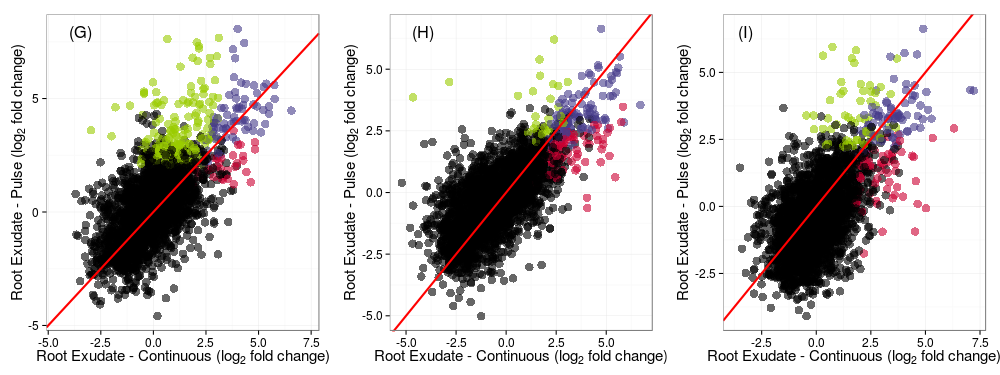

In [29]:
%%R -w 1000 -h 375

colours = c("slateblue4", "black", "#CC0033", "#99CC00")

p7 = ggplot(df3.14, aes(x = C13.100, y = C13.700, color = rspnse))
p7 = p7 + geom_point(alpha = 0.6, size = 4)
p7 = p7 + scale_color_manual(values=colours)
#p7 = p7 + stat_smooth(method = "lm", size = 1)
p7 = p7 + labs(x = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep="")))
p7 = p7 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p7 = p7 + ggtitle("A")
#p7 = p7 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p7 = p7 + theme_bw()
p7 = p7 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p7 = p7 + annotate("text", label = "(G)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p7 = p7 + theme(legend.position="none")


p8 = ggplot(df3.28, aes(x = C13.100, y = C13.700, color = rspnse))
p8 = p8 + geom_point(alpha = 0.6, size = 4)
p8 = p8 + scale_color_manual(values=colours)
#p8 = p8 + stat_smooth(method = "lm", size = 1)
p8 = p8 + labs(x = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep="")))
p8 = p8 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p8 = p8 + ggtitle("A")
#p8 = p8 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p8 = p8 + theme_bw()
p8 = p8 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p8 = p8 + annotate("text", label = "(H)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p8 = p8 + theme(legend.position="none")


p9 = ggplot(df3.45, aes(x = C13.100, y = C13.700, color = rspnse))
p9 = p9 + geom_point(alpha = 0.6, size = 4)
p9 = p9 + scale_color_manual(values=colours)
#p9 = p9 + stat_smooth(method = "lm", size = 1)
p9 = p9 + labs(x = expression(paste("Root Exudate - Continuous (", log[2]," fold change)",sep="")),
            y = expression(paste("Root Exudate - Pulse (", log[2]," fold change)",sep="")))
p9 = p9 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
#p9 = p9 + ggtitle("A")
#p9 = p9 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p9 = p9 + theme_bw()
p9 = p9 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)
p9 = p9 + annotate("text", label = "(I)", x=-Inf, y=Inf, size=5.75, hjust = -1, vjust = 2)
p9 = p9 + theme(legend.position="none")


p.combined3 = grid.arrange(p7, p8, p9, widths = c(1,1,1), heights = c(1,1,1), ncol = 3)

p.combined3

NULL


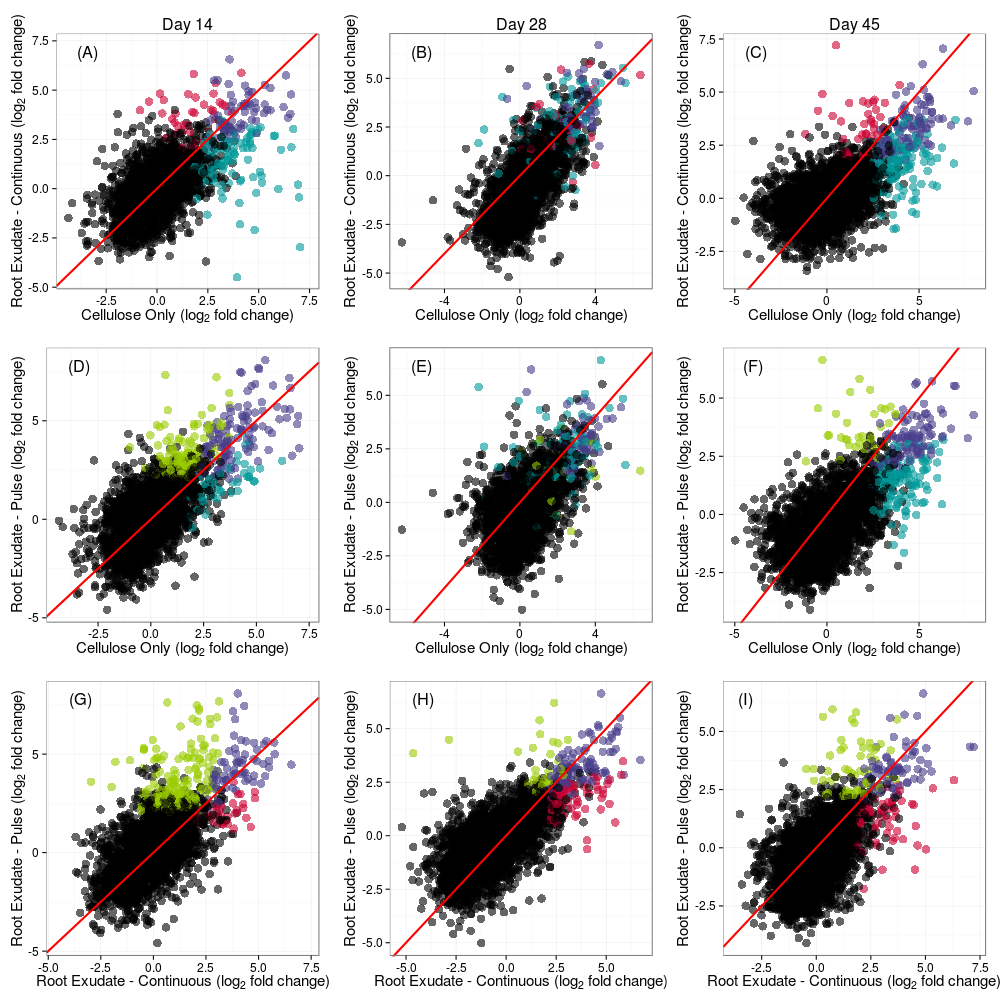

In [30]:
%%R -w 1000 -h 1000
p.combined4 = grid.arrange(p1, p2, p3,
                           p4, p5, p6,
                           p7, p8, p9, 
                           widths = c(1,1,1), heights = c(1,1,1), 
                           ncol = 3)

p.combined4

In [31]:
%%R -w 1000 -h 1000
pdf("figs/LinReg_Treatments_byDays.pdf", width = 15, height = 15)
grid.arrange(p1, p2, p3,
             p4, p5, p6,
             p7, p8, p9, 
             widths = c(1,1,1), heights = c(1,1,1), 
             ncol = 3)
dev.off()

png 
  2 


In [32]:
FileLink("figs/LinReg_Treatments_byDays.pdf")

/home/ashley/priming_exp/figs/LinReg_Treatments_byDays.pdf

In [33]:
%%R 
png("figs/LinReg_Treatments_byDays.png", width = 15, height = 15, units = "in", res = 600)
grid.arrange(p1, p2, p3,
             p4, p5, p6,
             p7, p8, p9, 
             widths = c(1,1,1), heights = c(1,1,1), 
             ncol = 3)
dev.off()

png 
  2 


In [34]:
FileLink("figs/LinReg_Treatments_byDays.png")

/home/ashley/priming_exp/figs/LinReg_Treatments_byDays.png